In [2]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [3]:
df =pd.read_sql_table('microwave', 'sqlite:///dissertation.db') 

In [4]:
df_copy = df.copy()

In [5]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [5]:
# prepare data for clustering
df_half['weekofyear']=df_half.index.week
df_half['day_categ']=df_half.index.day_name()
df_half['day_num']=df_half.index.weekday
#df_half['day']=df_half.index.day
df_half['hour']=df_half.index.hour


# prepare day_type --> weekday, weekend, holiday
df_half['day_type'] = df_half['day_num'].apply(lambda x: 'weekday' if x <5 else 'weekend')
df_half.loc[(df_half.index >= '2019-12-24 00:00:00') & (df_half.index < '2019-12-26 00:00:00'), 'day_type']='holiday'
df_half.loc[(df_half.index >= '2020-01-01 00:00:00') & (df_half.index < '2020-01-02 00:00:00'), 'day_type']='holiday'

# prepare morning, afternoon, and night 
df_half['time_of_day'] =df_half['hour'].apply(lambda x: 'morning' if (x>=7) & (x<= 12) else ('afternoon' if (x>12) & (x<=18) else 'night'))

# lockdown
df_half.loc[(df_half.weekofyear >=12) & (df_half.weekofyear <24), 'day_type'] = 'holiday'


df_half['hour']=df_half.index.strftime('%H')

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [23]:
df_half

,Half_Wh,weekofyear,day_categ,day_num,hour,day_type,time_of_day
time,,,,,,,
2019-12-23 00:00:00,0.0,52,Monday,0,00,weekday,night
2019-12-23 00:30:00,0.0,52,Monday,0,00,weekday,night
2019-12-23 01:00:00,0.0,52,Monday,0,01,weekday,night
2019-12-23 01:30:00,0.0,52,Monday,0,01,weekday,night
2019-12-23 02:00:00,0.0,52,Monday,0,02,weekday,night
...,...,...,...,...,...,...,...
2020-06-07 21:30:00,0.0,23,Sunday,6,21,holiday,night
2020-06-07 22:00:00,0.0,23,Sunday,6,22,holiday,night
2020-06-07 22:30:00,0.0,23,Sunday,6,22,holiday,night


In [7]:
# subset data until lockdown 23/03/2020  (13 weeks * 7day * 48 points =4368)
subset = 4368
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [103]:
# split into train and test sets
train_size = int(len(train_test) * 0.5)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

2184 2184


In [104]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [105]:
look_back=48
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [106]:
# add extra variables day_type and time of the day

# extract the train variables for same length
df_train_var=df_half[['day_categ','time_of_day','day_type']][:len(trainX)]
# get dummies
df_dum_train=pd.get_dummies(df_train_var)

# extract the test variables for same length
df_test_var=df_half[['day_categ','time_of_day','day_type']][len(trainX):len(trainX)+len(testX)]
# get dummies
df_dum_test=pd.get_dummies(df_test_var)

# extract the validation variables for same length
df_simu_var=df_half[['day_categ','time_of_day','day_type']][len(trainX)+len(testX):len(trainX)+len(testX)+len(simuX)]
# get dummies
df_dum_simu=pd.get_dummies(df_simu_var)
df_dum_simu['day_type_weekday']=0
df_dum_simu['day_type_weekend']=0

In [107]:
#to np
np_train=np.array(df_dum_train)

#to np
np_test=np.array(df_dum_test)

#to np
np_simu=np.array(df_dum_simu)

In [108]:
#concatenate trainX, testX, validX with variables, respectively
trainX_ok = np.concatenate((trainX, np_train),axis=1)
testX_ok = np.concatenate((testX, np_test),axis=1)
simuX_ok = np.concatenate((simuX, np_simu),axis=1)

In [109]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(125, input_dim=look_back+13, activation='relu'))
model.add(Dense(60, activation='relu'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history = model.fit(trainX_ok, trainY, epochs=250, batch_size=10, verbose=2)

Epoch 1/250
 - 1s - loss: 806.6786 - mse: 806.6784 - mae: 13.2081 - mape: 6201343488.0000
Epoch 2/250
 - 0s - loss: 672.3339 - mse: 672.3337 - mae: 10.9094 - mape: 4624783872.0000
Epoch 3/250
 - 0s - loss: 592.2582 - mse: 592.2582 - mae: 10.1630 - mape: 4256732416.0000
Epoch 4/250
 - 0s - loss: 607.0966 - mse: 607.0967 - mae: 10.1095 - mape: 4414811136.0000
Epoch 5/250
 - 0s - loss: 550.6310 - mse: 550.6310 - mae: 9.7563 - mape: 4247730176.0000
Epoch 6/250
 - 0s - loss: 502.8810 - mse: 502.8809 - mae: 9.1588 - mape: 3995806208.0000
Epoch 7/250
 - 0s - loss: 463.8834 - mse: 463.8835 - mae: 8.8571 - mape: 3832445440.0000
Epoch 8/250
 - 0s - loss: 432.5887 - mse: 432.5888 - mae: 8.5574 - mape: 3798756864.0000
Epoch 9/250
 - 0s - loss: 430.0295 - mse: 430.0295 - mae: 8.5741 - mape: 3786948352.0000
Epoch 10/250
 - 0s - loss: 383.7346 - mse: 383.7346 - mae: 7.8077 - mape: 3284452608.0000
Epoch 11/250
 - 0s - loss: 329.1272 - mse: 329.1272 - mae: 7.6190 - mape: 3376424448.0000
Epoch 12/250
 -

Epoch 94/250
 - 0s - loss: 42.3469 - mse: 42.3469 - mae: 2.1805 - mape: 862753600.0000
Epoch 95/250
 - 0s - loss: 39.6539 - mse: 39.6539 - mae: 2.1845 - mape: 880002432.0000
Epoch 96/250
 - 0s - loss: 30.3551 - mse: 30.3551 - mae: 1.8150 - mape: 741807744.0000
Epoch 97/250
 - 0s - loss: 29.0281 - mse: 29.0281 - mae: 1.8326 - mape: 746076288.0000
Epoch 98/250
 - 0s - loss: 40.4585 - mse: 40.4585 - mae: 2.1593 - mape: 827520192.0000
Epoch 99/250
 - 0s - loss: 30.5504 - mse: 30.5504 - mae: 1.8760 - mape: 705473728.0000
Epoch 100/250
 - 0s - loss: 30.0209 - mse: 30.0209 - mae: 1.9208 - mape: 807420032.0000
Epoch 101/250
 - 0s - loss: 34.2155 - mse: 34.2155 - mae: 1.9491 - mape: 764040384.0000
Epoch 102/250
 - 0s - loss: 50.9632 - mse: 50.9632 - mae: 2.3727 - mape: 948930624.0000
Epoch 103/250
 - 0s - loss: 38.6680 - mse: 38.6680 - mae: 2.2643 - mape: 919828736.0000
Epoch 104/250
 - 0s - loss: 34.2820 - mse: 34.2820 - mae: 2.1018 - mape: 833089536.0000
Epoch 105/250
 - 0s - loss: 33.4959 - 

Epoch 188/250
 - 0s - loss: 15.0916 - mse: 15.0916 - mae: 1.2657 - mape: 419522688.0000
Epoch 189/250
 - 0s - loss: 15.0766 - mse: 15.0766 - mae: 1.2285 - mape: 395467968.0000
Epoch 190/250
 - 0s - loss: 13.7400 - mse: 13.7400 - mae: 1.1641 - mape: 375026368.0000
Epoch 191/250
 - 0s - loss: 12.8814 - mse: 12.8814 - mae: 1.0681 - mape: 351813376.0000
Epoch 192/250
 - 0s - loss: 17.3285 - mse: 17.3285 - mae: 1.2382 - mape: 404609344.0000
Epoch 193/250
 - 0s - loss: 17.6550 - mse: 17.6550 - mae: 1.3406 - mape: 444765120.0000
Epoch 194/250
 - 0s - loss: 17.0100 - mse: 17.0100 - mae: 1.2976 - mape: 413746432.0000
Epoch 195/250
 - 0s - loss: 18.1420 - mse: 18.1420 - mae: 1.3122 - mape: 420544160.0000
Epoch 196/250
 - 0s - loss: 15.7582 - mse: 15.7582 - mae: 1.2113 - mape: 379821856.0000
Epoch 197/250
 - 0s - loss: 15.9422 - mse: 15.9422 - mae: 1.1912 - mape: 395580736.0000
Epoch 198/250
 - 0s - loss: 14.9882 - mse: 14.9882 - mae: 1.1631 - mape: 373660288.0000
Epoch 199/250
 - 0s - loss: 13.7

In [110]:
# model evalute
trainScore = model.evaluate(trainX_ok, trainY)
testScore = model.evaluate(testX_ok, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])
#print('Valid MSE: ', validScore[1], 'MAE: ', validScore[2])

2135/2135 [==============================] - 0s 50us/step
Train MSE:  13.588193893432617 MAE:  1.0319137573242188
Test MSE:  931.47607421875 MAE:  10.097618103027344


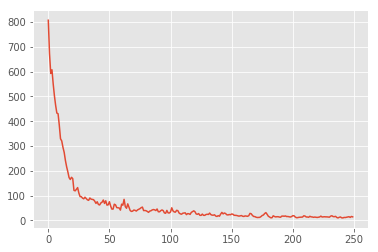

In [111]:
plt.plot(history.history['loss'])

In [112]:
trainPredict = model.predict(trainX_ok)
testPredict = model.predict(testX_ok)
simuPredict = model.predict(simuX_ok)
nextPredict = model.predict(testX_ok[-1:,:])

In [113]:
print(nextPredict,df_simu[0:1].values)

[[0.00108502]] [[0.]]


In [114]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.20467783975796172

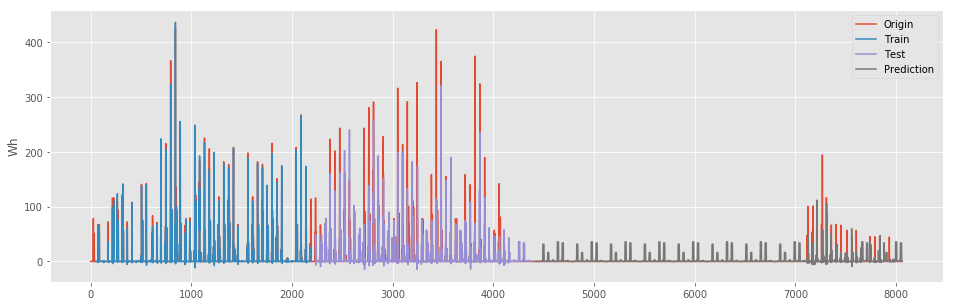

In [117]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [118]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

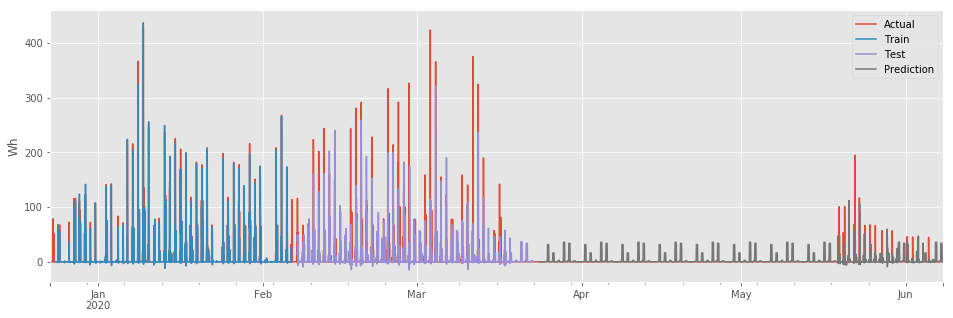

In [119]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

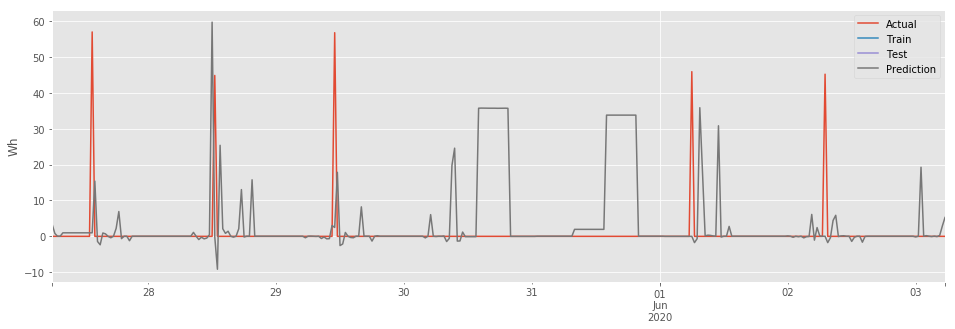

In [120]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

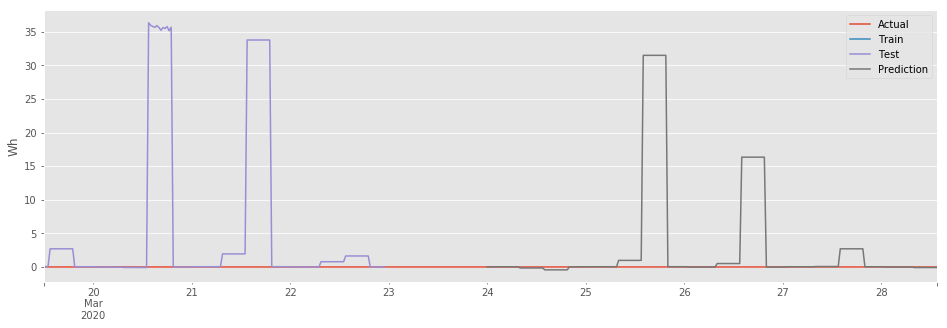

In [121]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

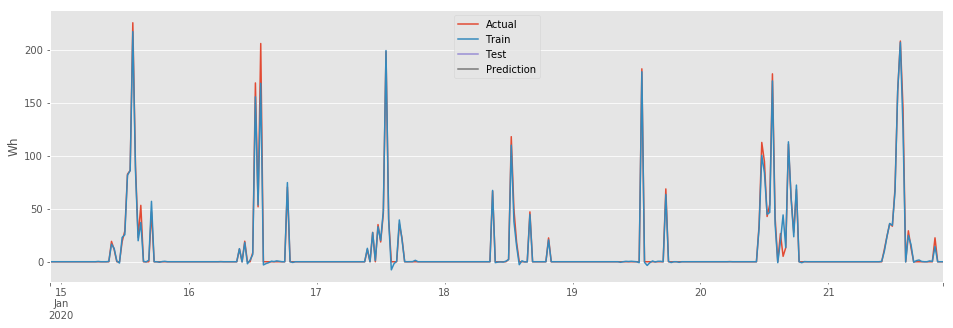

In [122]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [123]:
# save the model 
model.save('microwave_nolock_ann.h5')

In [6]:
# with lockdown
mad_mean_ratio =10.097*2184/df_half['Half_Wh'][4368-2184:4368].sum() 
mad_mean_ratio

1.2499304662736517